# TASK1

In [33]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2
import matplotlib.pyplot as plt

import numpy as np
import scipy.fftpack

import warnings
warnings.filterwarnings('ignore')

import dct

%matplotlib inline

Начнём с шумового сигнала и массива величин степени двойки:

In [34]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

Следующая функция берет массив результатов временного эксперимента, отображает результаты и выстраивает прямую линию.

In [40]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):    
    thinkplot.plot(ns, bests)
    thinkplot.config(xscale='log', yscale='log', legend=False)
    
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [41]:
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [42]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

In [43]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096])

Вот результаты для analysis1

64
124 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
312 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.46 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
5.46 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
28.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
208 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
1.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.215896159852855

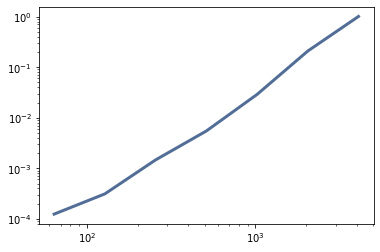

In [44]:
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

Расчетный наклон близок к 2, а не к 3, как ожидалось. Одна из возможностей состоит в том, что производительность np.linalg.solve почти квадратична в этом диапазоне размеров массива.

In [45]:
def analyze2(ys, fs, ts):
    
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Вот результаты для analysis2:

64
59.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
228 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
836 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
3.84 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
16.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2048
66.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
258 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.0327951145865506

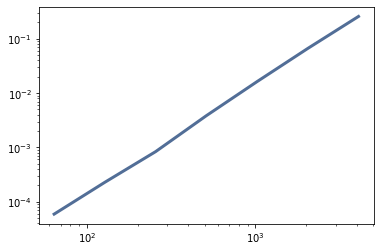

In [46]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

Как и ожидалось, результаты для analysis2 попадают в прямую линию с предполагаемым наклоном, близким к 2.

In [47]:
def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

Вот результаты для scipy.fftpack.dct

64
8.51 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
9.25 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
9.77 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
10.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
14.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
24.6 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
4096
46 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


0.3809384112664403

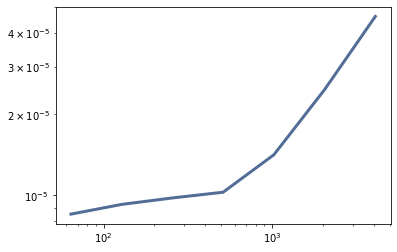

In [48]:
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

Эта реализация dct еще быстрее. Линия изогнута, что означает, что либо мы еще не видели асимптотическое поведение, либо асимптотическое поведение не является простым показателем. Фактически, как мы скоро увидим, время выполнения пропорционально log𝑛.

На следующем рисунке показаны все три кривые на одних и тех же осях.

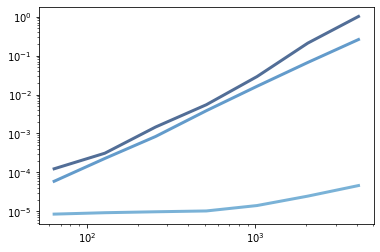

In [49]:
thinkplot.plot(ns, bests, label='analyze1')
thinkplot.plot(ns, bests2, label='analyze2')
thinkplot.plot(ns, bests3, label='fftpack.dct')
thinkplot.config(xscale='log', yscale='log', legend=False)

# TASK2

thinkdsp предоставляет класс Dct, похожий на Spectrum, но использующий DCT вместо FFT.

Возьмем запись саксофона из репозитория:

In [50]:
wave = thinkdsp.read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Выделим небольшой сегмент:

In [61]:
segment = wave.segment(start=1.0, duration=0.5)
segment.normalize()
segment.make_audio()

Построим DCT этого сегмента:

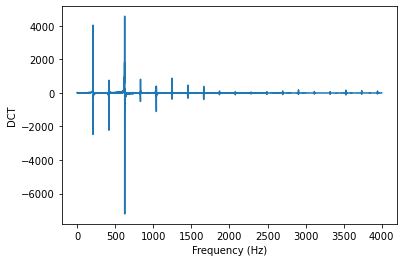

In [62]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='DCT')

Есть только несколько гармоник со значительной амплитудой, и многие записи близки к нулю.

Следующая функция принимает DCT и устанавливает для элементов ниже порога значение 0.

In [63]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

Если мы применим его к сегменту, мы можем удалить более 90% элементов:

20292	22050	92.02721088435374


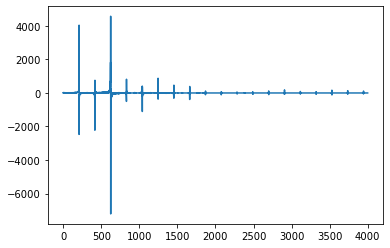

In [64]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

Результат схож с изначальным

In [65]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Чтобы сжать более длинный сегмент, мы можем сделать спектрограмму ДКП. Следующая функция похожа на wave.make_spectrogram за исключением того, что использует ДКП.

In [66]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2
    
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Теперь мы можем составить DCT-спектрограмму и применить компресс к каждому сегменту:

In [67]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

1018	1024	99.4140625
1016	1024	99.21875
1014	1024	99.0234375
1017	1024	99.31640625
1016	1024	99.21875
1017	1024	99.31640625
1016	1024	99.21875
1020	1024	99.609375
1014	1024	99.0234375
1005	1024	98.14453125
1009	1024	98.53515625
1015	1024	99.12109375
1015	1024	99.12109375
1016	1024	99.21875
1016	1024	99.21875
1015	1024	99.12109375
1017	1024	99.31640625
1020	1024	99.609375
1013	1024	98.92578125
1017	1024	99.31640625
1013	1024	98.92578125
1017	1024	99.31640625
1018	1024	99.4140625
1015	1024	99.12109375
1013	1024	98.92578125
794	1024	77.5390625
785	1024	76.66015625
955	1024	93.26171875
995	1024	97.16796875
992	1024	96.875
976	1024	95.3125
925	1024	90.33203125
802	1024	78.3203125
836	1024	81.640625
850	1024	83.0078125
882	1024	86.1328125
883	1024	86.23046875
891	1024	87.01171875
901	1024	87.98828125
902	1024	88.0859375
900	1024	87.890625
900	1024	87.890625
894	1024	87.3046875
904	1024	88.28125
901	1024	87.98828125
915	1024	89.35546875
913	1024	89.16015625
899	1024	87.79296875
905	1024	88.37

736	1024	71.875
782	1024	76.3671875
768	1024	75.0
778	1024	75.9765625
767	1024	74.90234375
774	1024	75.5859375
772	1024	75.390625
769	1024	75.09765625
774	1024	75.5859375
776	1024	75.78125
796	1024	77.734375
762	1024	74.4140625
766	1024	74.8046875
765	1024	74.70703125
783	1024	76.46484375
770	1024	75.1953125
799	1024	78.02734375
779	1024	76.07421875
774	1024	75.5859375
791	1024	77.24609375
797	1024	77.83203125
781	1024	76.26953125
754	1024	73.6328125
790	1024	77.1484375
790	1024	77.1484375
801	1024	78.22265625
783	1024	76.46484375
787	1024	76.85546875
805	1024	78.61328125
758	1024	74.0234375
785	1024	76.66015625
788	1024	76.953125
806	1024	78.7109375
818	1024	79.8828125
776	1024	75.78125
807	1024	78.80859375
802	1024	78.3203125
782	1024	76.3671875
812	1024	79.296875
803	1024	78.41796875
803	1024	78.41796875
787	1024	76.85546875
799	1024	78.02734375
786	1024	76.7578125
813	1024	79.39453125
813	1024	79.39453125
813	1024	79.39453125
803	1024	78.41796875
815	1024	79.58984375
792	1024	77.34

970	1024	94.7265625
969	1024	94.62890625
975	1024	95.21484375
963	1024	94.04296875
965	1024	94.23828125
975	1024	95.21484375
969	1024	94.62890625
966	1024	94.3359375
969	1024	94.62890625
984	1024	96.09375
981	1024	95.80078125
977	1024	95.41015625
982	1024	95.8984375
980	1024	95.703125
980	1024	95.703125
981	1024	95.80078125
982	1024	95.8984375
981	1024	95.80078125
987	1024	96.38671875
982	1024	95.8984375
982	1024	95.8984375
977	1024	95.41015625
982	1024	95.8984375
986	1024	96.2890625
984	1024	96.09375
986	1024	96.2890625
987	1024	96.38671875
996	1024	97.265625
995	1024	97.16796875
997	1024	97.36328125
999	1024	97.55859375
1002	1024	97.8515625
999	1024	97.55859375
1004	1024	98.046875
1002	1024	97.8515625
999	1024	97.55859375
1000	1024	97.65625
1007	1024	98.33984375
1010	1024	98.6328125
1012	1024	98.828125
1004	1024	98.046875
1000	1024	97.65625
1008	1024	98.4375
1005	1024	98.14453125
1011	1024	98.73046875
1011	1024	98.73046875
1009	1024	98.53515625
1005	1024	98.14453125
1007	1024	98.3398

В большинстве сегментов сжатияие составляет 75-80%.

Чтобы услышать, как это звучать, мы можем преобразовать спектрограмму обратно в волну и воспроизвести ее.

In [69]:
wave.make_audio()

In [68]:
wave2 = spectro.make_wave()
wave2.make_audio()

Выше представлены оригинальный сигнал и сигнал после сжатия.

При сжатии слышно характерный треск во время воспроизведения аудио, так что можно смело сказать, что нам удалось сжать аудиозапись.

# TASK3

Используем сигнал с пилообразной формой волны

In [70]:
signal = thinkdsp.SawtoothSignal(freq=300, offset=0)
wave = signal.make_wave(duration=0.5, framerate=40000)
wave.make_audio()

Пилообразная волна:

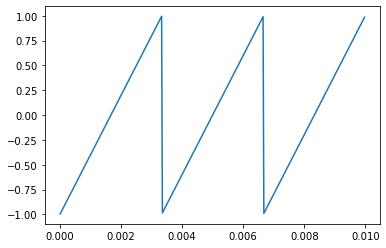

In [71]:
wave.segment(duration=0.01).plot()

Выведем спектр данной волны:

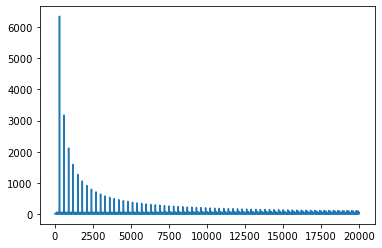

In [72]:
spectrum = wave.make_spectrum()
spectrum.plot()

Рассмотрим угловую часть спектра.

In [73]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    thinkplot.plot(spectrum.fs, angles, style='x')
    thinkplot.config(xlim=[0, spectrum.max_freq],
                     ylim =[-np.pi, np.pi])

На большинстве частот амплитуда мала, а угол - практически случайное число. При построении всех углов получается беспорядок.

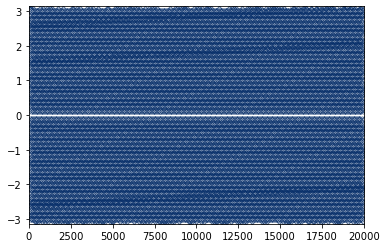

In [74]:
plot_angle(spectrum, thresh=0)
thinkplot.config(xlim=[0, spectrum.max_freq], ylim = [-np.pi, np.pi])

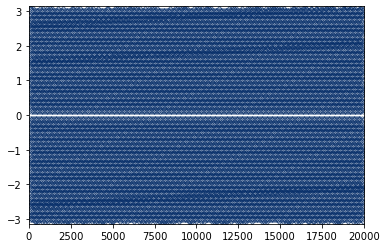

In [75]:
plot_angle(spectrum, thresh=1)
thinkplot.config(xlim=[0, spectrum.max_freq], ylim = [-np.pi, np.pi])

Когда мы выбираем только те частоты, где величина превышает пороговое значение, мы видим, что в углах есть структура. Каждая гармоника смещена от предыдущей на доли радиана.

Следующая функция отображает амплитуды, углы и форму волны для заданного спектра.

In [76]:
def plot_three(spectrum, thresh=1):
    thinkplot.preplot(cols=3)
    spectrum.plot()
    thinkplot.subplot(2)
    plot_angle(spectrum, thresh=thresh)
    thinkplot.subplot(3)
    wave = spectrum.make_wave()
    wave.segment(duration=0.01).plot()
    wave.apodize()
    display(wave.make_audio())

С помощью функции отобразим неизмененный спектр

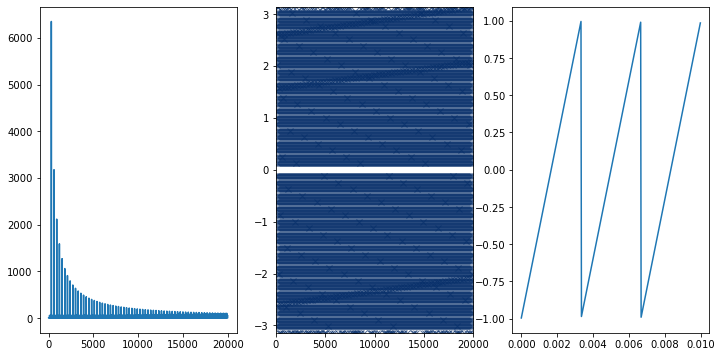

In [77]:
plot_three(spectrum)

Рассмотрим ситуация когда все углы устанавливаются в 0, для этого напишем метод позволяющий это сделать.

In [78]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

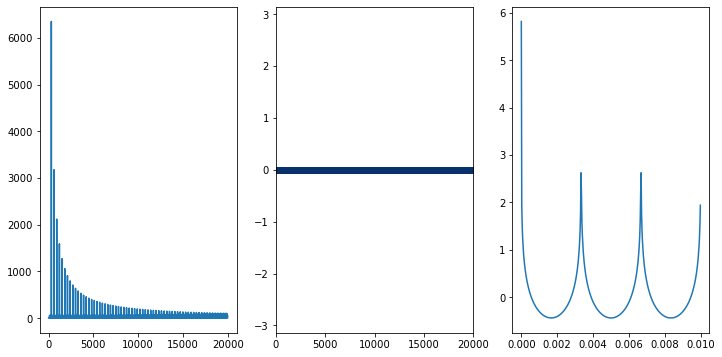

In [79]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2)

Если мы умножим комплексные компоненты на  exp(𝑖𝜙) , это приведет к добавлению  𝜙  к углам:

In [80]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

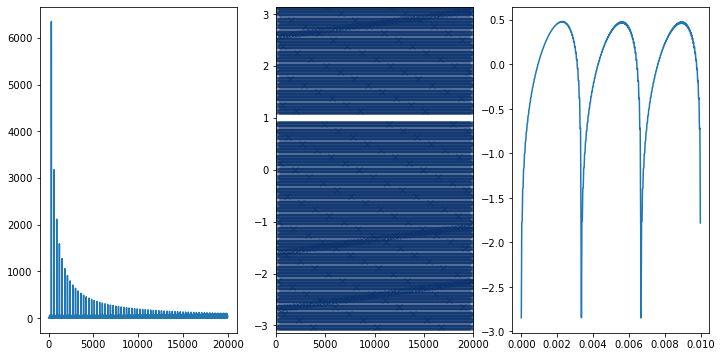

In [81]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3)

Рассмотрим ситуация когда все углы устанавливаются в случайные значения, для этого напишем метод позволяющий это сделать.

In [82]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

Влияние на форму волны сильное, но воспринимаемый звук остаётся плюс минус прежним, правда он приобрёл "металлический" эффект.

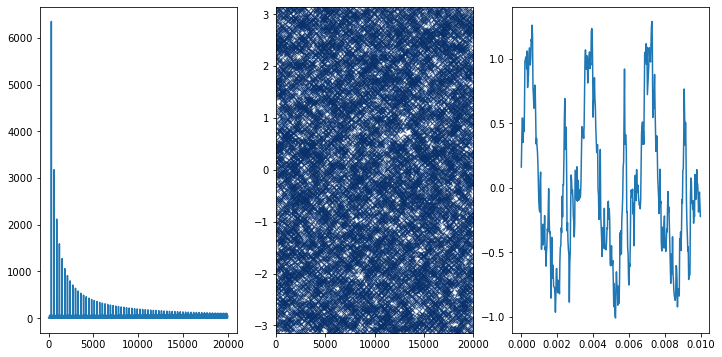

In [83]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4)

С более естественными звуками результаты несколько отличаются. Рассмотрим запись гобоя.

In [84]:
wave = thinkdsp.read_wave('120994__thirsk__120-oboe.wav')
wave.make_audio()

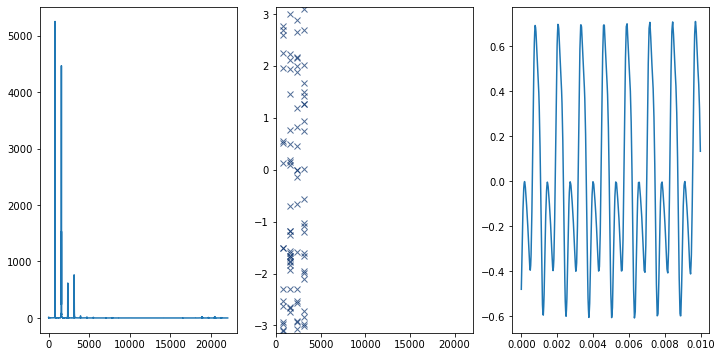

In [85]:
segment = wave.segment(start=0.2, duration=0.6)
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Здесь все углы установлены в ноль.

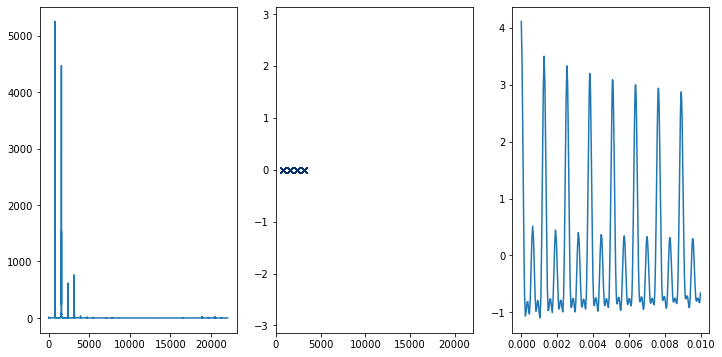

In [86]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Здесь все углы повернуты на 1 радиан.

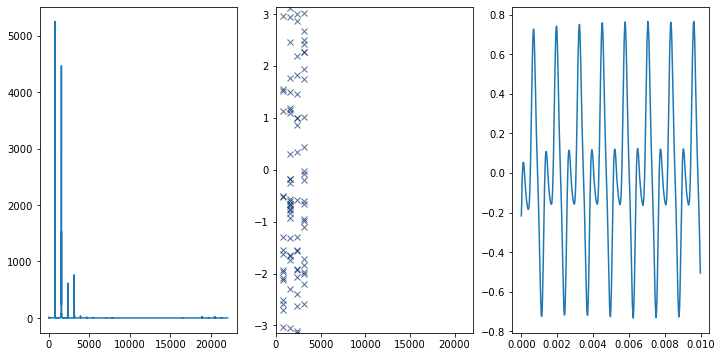

In [87]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Здесь все углы принимают случайные значения.

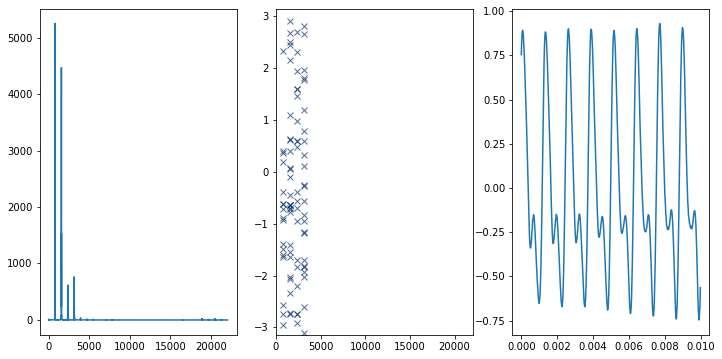

In [88]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Установка углов в ноль понижает уровень громкости, поворот углов на радиан не вызвал особых изменений. В случае со случайными значениями появились эффекты ревебрации.

Проделаем те же операции с небольшим сегментом звука саксофона:

In [89]:
wave = thinkdsp.read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

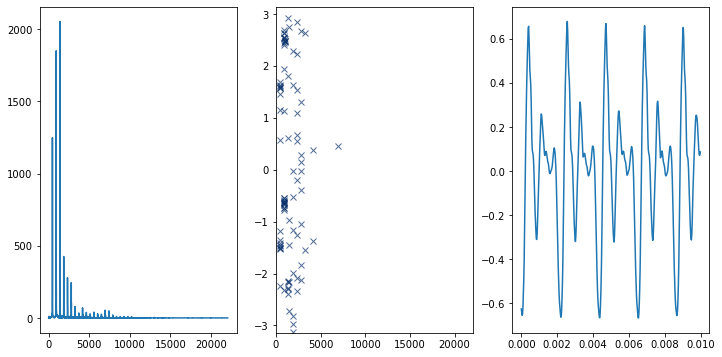

In [91]:
segment = wave.segment(start=2.0, duration=0.5)
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Установим значения в 0

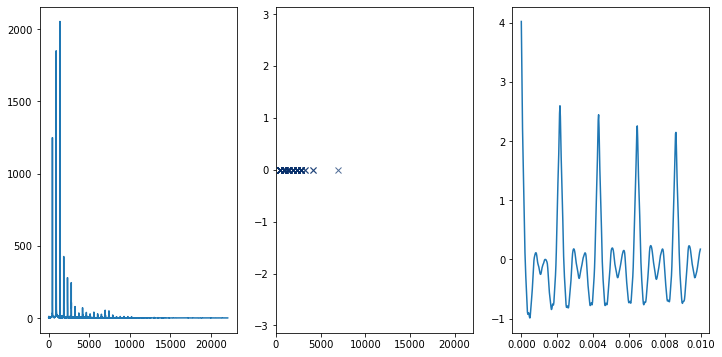

In [92]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Повернем углы на 1 радиан:

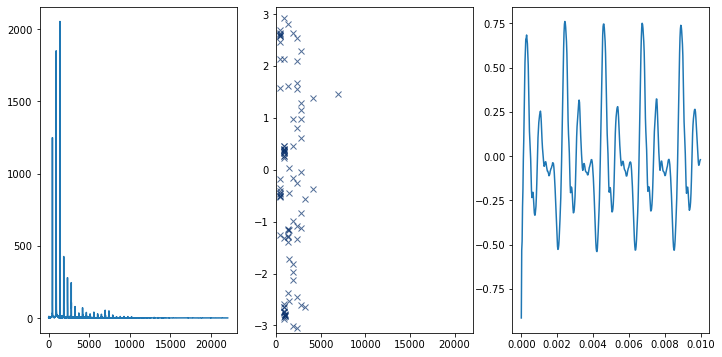

In [93]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Установим случайные значения:

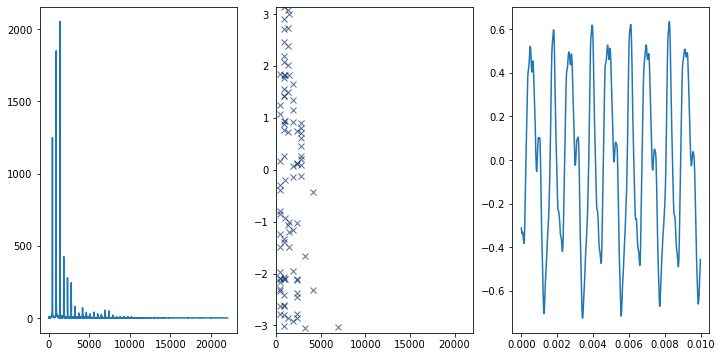

In [94]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Таким образом после всех преобразований можно сделать вывод, что при установлении значений углов в 0 звук теряет небольшую часть громкости и становится тише, в случае с поворотом углом звук не изменяется, а при установлении случйных значений мы начинаем слышать шумы которые снижают качество звука (личная оценка)

Саксофон отличается от других звуков тем, что основной компонент не является доминирующим. Для подобных звуков ухо использует что-то вроде автокорреляции в дополнение к спектральному анализу, и возможно, что этот вторичный режим анализа более чувствителен к фазовой структуре.

Для этого подтверждения этой теории проделаем следующие действия:

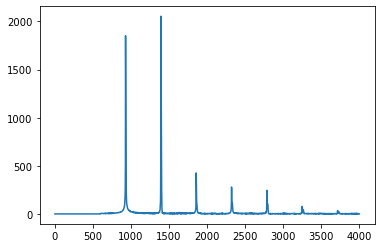

In [95]:
spectrum.high_pass(600)
spectrum.plot(high=4000)

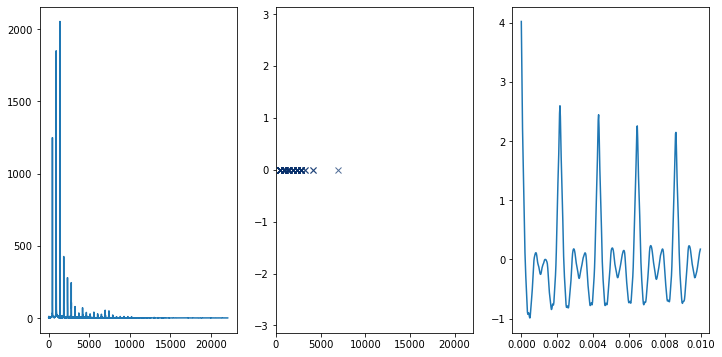

In [96]:
plot_three(spectrum2, thresh=50)

Установим углы в 0

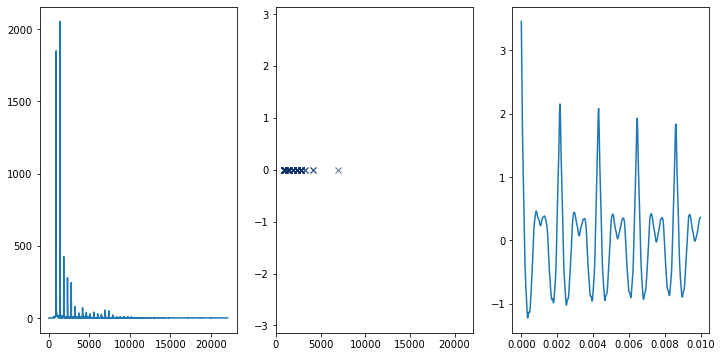

In [97]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Повернем углы на радиан

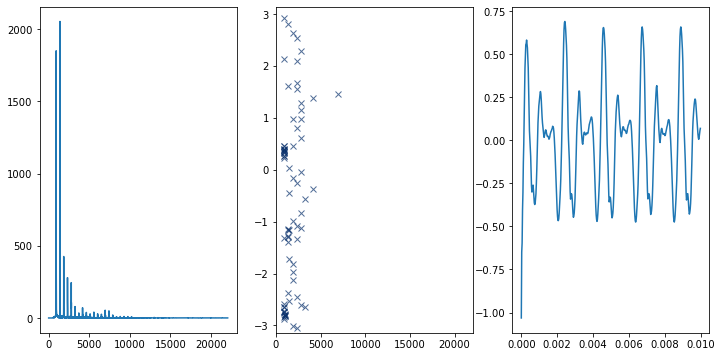

In [98]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Установим случайные значения:

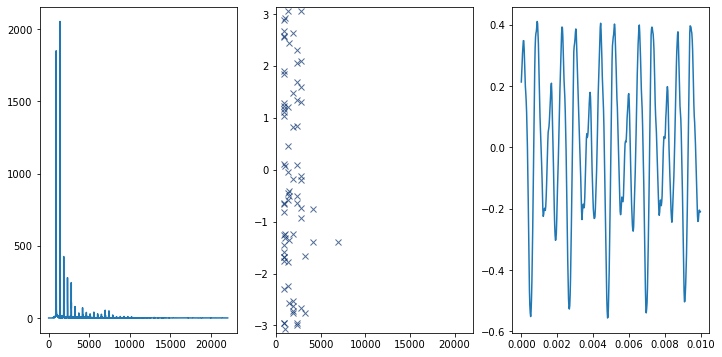

In [99]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Для этого сегмента изменение фазовой структуры имеет слышимый эффект, особенно случайные углы.

Если ухо использует что-то вроде автокорреляции для анализа подобных звуков, мы можем ожидать увидеть изменения в функции автокорреляции при изменении фазовой структуры.

Следующие функции строят АКФ для этих сегментов:

In [100]:
def autocorr(segment):
    corrs = np.correlate(segment.ys, segment.ys, mode='same')
    N = len(corrs)
    lengths = range(N, N//2, -1)

    half = corrs[N//2:].copy()
    half /= lengths
    half /= half[0]
    return half

In [101]:
def plot_acf(spectrum):
    corrs = autocorr(spectrum.make_wave())
    thinkplot.plot(corrs[:200], linewidth=1)

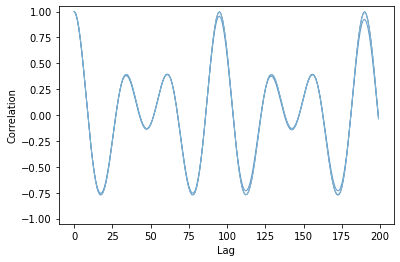

In [102]:
plot_acf(spectrum)
plot_acf(spectrum2)
plot_acf(spectrum3)
plot_acf(spectrum4)
thinkplot.config(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

Изменение фазовой структуры оказывает слабое влияние на АКФ, но нет того, что явно объясняет изменения в воспринимаемом звуке.

Для таких звуков, которые имеют простую гармоническую структуру, мы не слышим изменений в фазовой структуре, при условии, что гармоническая структура не изменилась.